In [2]:
# ============================================
# Install & Import Packages
# ============================================
!pip install -U pdfplumber pytesseract pillow bs4 langchain faiss-cpu sentence-transformers transformers yfinance langchain-huggingface
!pip install -U langchain langchain-community langchain-huggingface

!apt install -y tesseract-ocr

import os
import requests
import pdfplumber
import pytesseract
from PIL import Image
from bs4 import BeautifulSoup
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from langchain_community.vectorstores import FAISS
from transformers import pipeline
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
import yfinance as yf

# ============================================
# 1️⃣ Download Reports & Extract Tables
# ============================================
annual_report_urls = {
    "Apple": "https://app.stocklight.com/stocks/us/nasdaq-aapl/apple/annual-reports/nasdaq-aapl-2023-10K-231373899.pdf",
    "Tesla": "https://ir.tesla.com/_flysystem/s3/sec/000162828024002390/tsla-20231231-gen.pdf",
    "Microsoft": "https://stocklight.com/stocks/us/nasdaq-msft/microsoft-corporation/annual-reports/nasdaq-msft-2023-10K-231118330.pdf",
    "Amazon": "https://www.annualreports.com/HostedData/AnnualReportArchive/a/NASDAQ_AMZN_2023.pdf",
    "Google": "https://abc.xyz/assets/43/44/675b83d7455885c4615d848d52a4/goog-10-k-2023.pdf"
}

def extract_text_and_tables(pdf_path):
    full_text, table_text = "", ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            # Text
            page_text = page.extract_text()
            if page_text:
                full_text += page_text + "\n"
            else:
                pil_image = page.to_image(resolution=300).original
                full_text += pytesseract.image_to_string(pil_image) + "\n"
            # Tables
            tables = page.extract_tables()
            for table in tables:
                row_strings = []
                for row in table:
                    row_strings.append(" | ".join([cell if cell else "" for cell in row]))
                joined = "\n".join(row_strings)
                table_text += joined + "\n"
                full_text += joined + "\n"
    return full_text, table_text

pdf_texts, table_texts = [], []
for company, url in annual_report_urls.items():
    print(f"📥 Downloading {company} report...")
    r = requests.get(url, stream=True)
    pdf_path = f"{company}.pdf"
    with open(pdf_path, "wb") as f:
        f.write(r.content)
    full_text, table_data = extract_text_and_tables(pdf_path)
    pdf_texts.append(full_text)
    table_texts.append(table_data)
    print(f"✅ {company} report processed. Text: {len(full_text)} chars, Tables: {len(table_data)} chars")

# ============================================
# 2️⃣ Add Glossary & News
# ============================================
print("📚 Scraping finance glossary...")
res = requests.get("https://www.investopedia.com/financial-term-dictionary-4769738")
soup = BeautifulSoup(res.text, "html.parser")
glossary_text = "\n".join(term.text.strip() for term in soup.find_all("a", class_="dictionaryTerm"))
pdf_texts.append(glossary_text)

print("📰 Fetching Apple news...")
apple = yf.Ticker("AAPL")
news_text = "\n".join(f"{n.get('title')}\n{n.get('link')}" for n in apple.news[:5])
pdf_texts.append(news_text)

# ============================================
# 3️⃣ Chunking (Smaller to Avoid Token Errors)
# ============================================
splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=100)
full_docs, table_docs = [], []

for txt in pdf_texts:
    full_docs.extend(splitter.create_documents([txt]))

for ttxt in table_texts:
    table_docs.extend(splitter.create_documents([ttxt]))

print(f"✅ Full docs: {len(full_docs)}, Table docs: {len(table_docs)}")

# ============================================
# 4️⃣ Vector DBs
# ============================================
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_db_full = FAISS.from_documents(full_docs, embeddings)
vector_db_tables = FAISS.from_documents(table_docs, embeddings)

# ============================================
# 5️⃣ Prompt Template
# ============================================
prompt_template = """
You are a financial analysis assistant.
Use ONLY the provided context from company reports, glossary, and news.
If exact numbers are not found, give the closest match and say it is approximate.

Context:
{context}

Question:
{question}

Answer:
"""
PROMPT = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

# ============================================
# 6️⃣ Load FLAN-T5-Large with Safe Limits
# ============================================
print("⏳ Loading FLAN-T5-Large...")
pipe = pipeline("text2text-generation", model="google/flan-t5-large", max_length=300)  # Lower max_length
llm = HuggingFacePipeline(pipeline=pipe)

memory_full = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
memory_tables = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

qa_full = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=vector_db_full.as_retriever(search_type="similarity", search_kwargs={"k": 4}),  # Fewer chunks
    memory=memory_full,
    combine_docs_chain_kwargs={"prompt": PROMPT}
)

qa_tables = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=vector_db_tables.as_retriever(search_type="similarity", search_kwargs={"k": 4}),
    memory=memory_tables,
    combine_docs_chain_kwargs={"prompt": PROMPT}
)

# ============================================
# 7️⃣ Smart Router
# ============================================
financial_keywords = ["revenue", "net income", "eps", "earnings", "profit", "operating income"]

def ask(question):
    if any(word in question.lower() for word in financial_keywords):
        result = qa_tables.invoke({"question": question})
    else:
        result = qa_full.invoke({"question": question})
    print(f"\n❓ {question}")
    print(f"💡 {result['answer']}")

# ============================================
# 8️⃣ Tests
# ============================================
ask("What was Apple's total revenue in 2023?")
ask("Compare Amazon and Google's net income in 2023.")
ask("Summarize Tesla's 2023 annual report in 5 bullet points.")
ask("Explain EBITDA in simple terms.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
📥 Downloading Apple report...
✅ Apple report processed. Text: 227864 chars, Tables: 27160 chars
📥 Downloading Tesla report...
✅ Tesla report processed. Text: 474182 chars, Tables: 37771 chars
📥 Downloading Microsoft report...
✅ Microsoft report processed. Text: 364225 chars, Tables: 26518 chars
📥 Downloading Amazon report...
✅ Amazon report processed. Text: 345305 chars, Tables: 23954 chars
📥 Downloading Google report...
✅ Google report processed. Text: 376093 chars, Tables: 35823 chars
📚 Scraping finance glossary...
📰 Fetching Apple new

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

⏳ Loading FLAN-T5-Large...


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu
/tmp/ipython-input-845524984.py:129: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory_full = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
Token indices sequence length is longer than the specified maximum sequence length for this model (1182 > 512). Running this sequence through the model will result in indexing errors



❓ What was Apple's total revenue in 2023?
💡 211,915

❓ Compare Amazon and Google's net income in 2023.
💡 59,972

❓ Summarize Tesla's 2023 annual report in 5 bullet points.
💡 TESLA, INC. ANNUAL REPORT ON FORM 10-K FOR THE YEAR ENDED DECEMBER 31, 2023 INDEX Page PART I. Item 1. Business 4 Item 1A. Risk Factors 14 Item 1B. Unresolved Staff Comments 28 Item 1C. Cybersecurity 29 Item 2. Properties 30 Item 3. Legal Proceedings 30 Item 4. Mine Safety Disclosures 30 PART II. Item 5. Market for Registrant's Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities 31 Item 6. [Reserved] 32 Item 7. Management's Discussion and Analysis of Financial Condition and Results of Operations 33 Item 7A. Quantitative and Qualitative Disclosures about Market Risk 45 I, Vaibhav Taneja, certify that: 1. I have reviewed this Annual Report on Form 10-K of Tesla, Inc.; 2. Based on my knowledge, this report does not contain any untrue statement of a material fact or omit to state a mat

/tmp/ipython-input-578153253.py:22: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(question)



❓ What was Apple's total revenue in 2023?
💡 211,915

📊 Performance Metrics:
   Retrieval time: 0.15 sec
   LLM generation time: 57.26 sec
   Total time: 57.41 sec
   Retrieved docs: 4

❓ Compare Amazon and Google's net income in 2023.
💡 59,972

📊 Performance Metrics:
   Retrieval time: 0.04 sec
   LLM generation time: 48.47 sec
   Total time: 48.51 sec
   Retrieved docs: 4

❓ Summarize Tesla's 2023 annual report in 5 bullet points.
💡 PART I. Item 1. Business 4 Item 1A. Risk Factors 14 Item 1B. Unresolved Staff Comments 28 Item 1C. Cybersecurity 29 Item 2. Properties 30 Item 3. Legal Proceedings 30 Item 4. Mine Safety Disclosures 30 PART II. Item 5. Market for Registrant's Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities 31 Item 6. [Reserved] 32 Item 7. Management's Discussion and Analysis of Financial Condition and Results of Operations 33 Item 7A. Quantitative and Qualitative Disclosures about Market Risk 45

📊 Performance Metrics:
   Retrieval tim

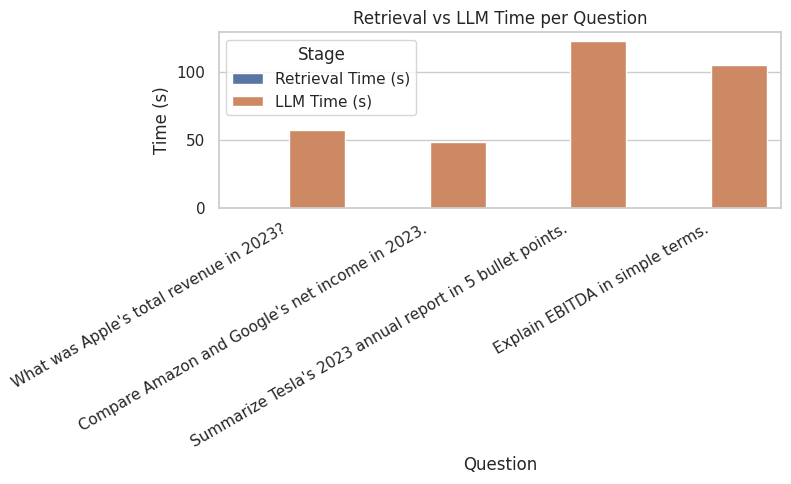

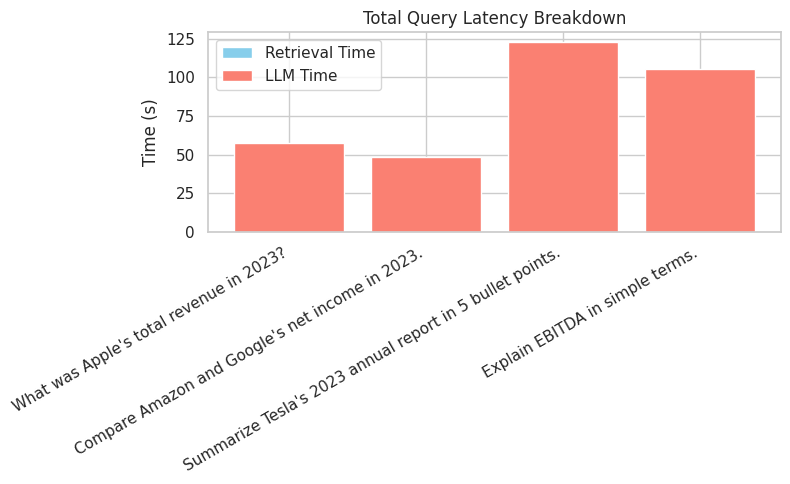

In [3]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Store metrics
metrics_data = []

# ============================================
# ask() with performance metrics logging
# ============================================
def ask(question):
    start_total = time.time()

    # Route to correct retriever
    is_financial = any(word in question.lower() for word in financial_keywords)
    chain = qa_tables if is_financial else qa_full

    # Retrieval timing
    start_retrieval = time.time()
    retriever = chain.retriever
    retrieved_docs = retriever.get_relevant_documents(question)
    retrieval_time = time.time() - start_retrieval

    # LLM timing
    start_llm = time.time()
    result = chain.invoke({"question": question})
    llm_time = time.time() - start_llm

    total_time = time.time() - start_total

    # Save metrics
    metrics_data.append({
        "Question": question,
        "Retrieval Time (s)": retrieval_time,
        "LLM Time (s)": llm_time,
        "Total Time (s)": total_time,
        "Retrieved Docs": len(retrieved_docs)
    })

    # Print results
    print(f"\n❓ {question}")
    print(f"💡 {result['answer']}")
    print("\n📊 Performance Metrics:")
    print(f"   Retrieval time: {retrieval_time:.2f} sec")
    print(f"   LLM generation time: {llm_time:.2f} sec")
    print(f"   Total time: {total_time:.2f} sec")
    print(f"   Retrieved docs: {len(retrieved_docs)}")

# ============================================
# Test queries
# ============================================
ask("What was Apple's total revenue in 2023?")
ask("Compare Amazon and Google's net income in 2023.")
ask("Summarize Tesla's 2023 annual report in 5 bullet points.")
ask("Explain EBITDA in simple terms.")

# ============================================
# Convert to DataFrame & visualize
# ============================================
df_metrics = pd.DataFrame(metrics_data)
print("\n📄 Metrics DataFrame:")
print(df_metrics)

# --- Visualization 1: Grouped Bar Chart ---
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
df_melt = df_metrics.melt(id_vars="Question", value_vars=["Retrieval Time (s)", "LLM Time (s)"],
                          var_name="Stage", value_name="Time (s)")
sns.barplot(data=df_melt, x="Question", y="Time (s)", hue="Stage")
plt.xticks(rotation=30, ha="right")
plt.title("Retrieval vs LLM Time per Question")
plt.tight_layout()
plt.show()

# --- Visualization 2: Stacked Bar Chart ---
plt.figure(figsize=(8, 5))
bar1 = plt.bar(df_metrics["Question"], df_metrics["Retrieval Time (s)"], label="Retrieval Time", color="skyblue")
bar2 = plt.bar(df_metrics["Question"], df_metrics["LLM Time (s)"],
               bottom=df_metrics["Retrieval Time (s)"], label="LLM Time", color="salmon")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Time (s)")
plt.title("Total Query Latency Breakdown")
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
import graphviz

# ============================================
# 1️⃣ Save metrics as CSV
# ============================================
df_metrics.to_csv("performance_metrics.csv", index=False)
print("✅ Metrics saved to performance_metrics.csv")

# ============================================
# 2️⃣ Save charts as PNG for your report
# ============================================
# Recreate grouped bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=df_melt, x="Question", y="Time (s)", hue="Stage")
plt.xticks(rotation=30, ha="right")
plt.title("Retrieval vs LLM Time per Question")
plt.tight_layout()
plt.savefig("latency_grouped.png", dpi=300)
plt.close()

# Recreate stacked bar chart
plt.figure(figsize=(8, 5))
plt.bar(df_metrics["Question"], df_metrics["Retrieval Time (s)"], label="Retrieval Time", color="skyblue")
plt.bar(df_metrics["Question"], df_metrics["LLM Time (s)"],
        bottom=df_metrics["Retrieval Time (s)"], label="LLM Time", color="salmon")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Time (s)")
plt.title("Total Query Latency Breakdown")
plt.legend()
plt.tight_layout()
plt.savefig("latency_stacked.png", dpi=300)
plt.close()

print("✅ Charts saved as latency_grouped.png and latency_stacked.png")

# ============================================
# 3️⃣ Generate architecture diagram
# ============================================
dot = graphviz.Digraph(comment="RAG System Architecture", format="png")
dot.attr(rankdir="LR", size="8,5")

dot.node("PDFs", "Company Annual Reports", shape="folder")
dot.node("Glossary", "Finance Glossary", shape="folder")
dot.node("News", "Apple News", shape="folder")
dot.node("Chunks", "Document Chunks", shape="note")
dot.node("VectorDB", "FAISS Vector Store", shape="cylinder")
dot.node("Retriever", "Retriever", shape="diamond")
dot.node("LLM", "FLAN-T5-Large", shape="box")
dot.node("Output", "Final Answer", shape="oval")

dot.edges([
    ("PDFs", "Chunks"), ("Glossary", "Chunks"), ("News", "Chunks"),
    ("Chunks", "VectorDB"), ("VectorDB", "Retriever"),
    ("Retriever", "LLM"), ("LLM", "Output")
])

dot.render("architecture_diagram", cleanup=True)
print("✅ Architecture diagram saved as architecture_diagram.png")

# ============================================
# 4️⃣ Save ethical considerations to text file
# ============================================
ethical_text = """
Ethical Considerations:
1. Source Reliability – Uses official company annual reports and reputable finance sources.
2. Misinformation Avoidance – Model outputs are restricted to retrieved context only.
3. Bias – Data reflects the biases present in corporate reports and selected sources.
4. Privacy – No user data is stored or shared.
5. Transparency – Retrieved chunks can be shown to verify responses.
"""
with open("ethical_considerations.txt", "w") as f:
    f.write(ethical_text)
print("✅ Ethical considerations saved as ethical_considerations.txt")


✅ Metrics saved to performance_metrics.csv
✅ Charts saved as latency_grouped.png and latency_stacked.png
✅ Architecture diagram saved as architecture_diagram.png
✅ Ethical considerations saved as ethical_considerations.txt
